In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
from p5lib import *
import pickle
import os.path

%matplotlib inline

### Load and preprocess data

The method ```preprocess_data``` chooses only the selected potential features and combine some columns that are mutually exclusive (such as 4 year college and < 4 year college). It also removes data that does not have Completion or Retention data because those are the target features. 

The result from preprocessing is stored in a pickle file so we can reload it much faster. 

In [2]:
pickle_file = 'reduced_data.pickle'
if os.path.isfile(pickle_file):
    data = pickle.load(open(pickle_file, "rb"))
else:
    data = pd.read_csv('MERGED2013_PP.csv')
    # print data.shape
    data = preprocess_data(data)
    pickle.dump(data, open(pickle_file, "wb"))

print data.shape

(6007, 45)


### Split data into features and targets (X and y) 

We also get rid of data that are outliers (data with retention rate 0)

In [3]:
X = data[['CONTROL', 'DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'PAR_ED_PCT_1STGEN', 
          'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 'UGDS', 
          'WDRAW_DEBT_MDN', 'L4_COLLEGE', 'NPT4', 'NUM4', 
          'PFTFTUG1_EF', 'PFTFAC',
          'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 'AVGFACSAL', 'COSTT4_A',
          'CCSIZSET', 'CCUGPROF', 'CCBASIC', # carnegie classification data
          'C150', 'RET_FT']]

# remove noise, this bumps up the r2 score pretty nicely
# X = X[~((X.RET_FT == 0) & (X.C150 > 0.5))]
# X = X[~((X.C150 == 0) & (X.RET_FT > 0.5))]
# X = X[~((X.C150 == 1) & (X.RET_FT < 0.5))]
# X = X[~((X.RET_FT == 1) & (X.C150 < 0.5))]
X = X[~(X.RET_FT == 0)]

y = X[['C150', 'RET_FT']]
X = X.drop('C150', 1)
X = X.drop('RET_FT', 1)
print X.shape
print y.shape
print len(X.dropna())


(5960, 28)
(5960, 2)
1146


### Fill missing values with the means

In [4]:
fill_cols_with_mean = ['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'WDRAW_DEBT_MDN',
                       'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 
                       'UG25abv', 'NPT4', 'NUM4', 'PFTFTUG1_EF', 'PFTFAC', 'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 
                       'AVGFACSAL', 'COSTT4_A']

for col in fill_cols_with_mean:
    if col in X:
        X[col] = X[col].fillna(X[col].mean())

In [5]:
print_num_data_for_each_features(X)

Number of available data for each feature (not counting the NaN values)
CONTROL             Control (public/private)                      5960
DEBT_MDN            Median debt                                   5960
DEP_INC_AVG         Avg income dependent stu                      5960
GRAD_DEBT_MDN       Median debt complete                          5960
IND_INC_AVG         Avg income independent stu                    5960
INEXPFTE            Expense per FTE student                       5960
PAR_ED_PCT_1STGEN   % 1st gen students                            5960
PAR_ED_PCT_HS       % parent education high school                5960
PAR_ED_PCT_MS       % parent education middle school              5960
PAR_ED_PCT_PS       % parent education post secondary             5960
PCTFLOAN            % Fed student loan                            5960
PCTPELL             % Pell Grant receiver                         5960
UG25abv             % undergrad > 25 yr                           5960
UGDS 

### Scale data

Process non-categorical data using standard scaler so they all have 0 means. 

In [6]:
from sklearn import preprocessing

# take features of type cost/money, and percentage (between 0 and 1) and preprocess with standard scaler
# and then use these preprocessed features for PCA
tmpX = X[['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'UGDS', 'WDRAW_DEBT_MDN', 'NPT4', 
          'NUM4', 'SAT_AVG_ALL', 'ACTCMMID', 'AVGFACSAL', 'COSTT4_A',
          'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 
          'PFTFTUG1_EF', 'PFTFAC', 'ADM_RATE_ALL'
         ]]

scaler = preprocessing.MinMaxScaler()
scaledX = scaler.fit_transform(tmpX)


tmp1X = np.array(pd.get_dummies(X['CONTROL']))
tmp2X = X['L4_COLLEGE'].astype(int)
tmp2X = np.reshape(tmp2X, (len(tmp2X), 1)) 

tmp3X = np.array(pd.get_dummies(X['CCSIZSET']))
tmp4X = np.array(pd.get_dummies(X['CCUGPROF']))
tmp5X = np.array(pd.get_dummies(X['CCBASIC']))

print scaledX.shape

print tmp1X.shape, tmp2X.shape, tmp3X.shape, tmp4X.shape, tmp5X.shape

scaledX = np.concatenate((scaledX, tmp1X, tmp2X, tmp3X, tmp4X, tmp5X), axis=1)
print scaledX.shape

(5960, 23)
(5960, 3) (5960, 1) (5960, 17) (5960, 14) (5960, 33)
(5960, 91)


### Use PCA for dimensional reduction

[  2.03458725e-01   1.51871472e-01   5.37577916e-02   4.84174096e-02
   3.77580745e-02   2.98615119e-02   2.71990976e-02   2.58104019e-02
   2.31844269e-02   2.12800527e-02   1.93243234e-02   1.79987644e-02
   1.73247051e-02   1.66203269e-02   1.54408154e-02   1.43259467e-02
   1.32326176e-02   1.23261970e-02   1.18631091e-02   1.07979776e-02
   1.01686927e-02   9.63617644e-03   9.43157443e-03   8.94615999e-03
   8.87146308e-03   8.42883436e-03   8.37980531e-03   8.30665806e-03
   7.76523851e-03   7.53005907e-03   7.39238270e-03   7.32622857e-03
   6.92850358e-03   6.67825064e-03   6.16830698e-03   5.74828536e-03
   5.51253751e-03   5.44698278e-03   5.12194874e-03   5.07790782e-03
   4.95398012e-03   4.89498666e-03   4.66001128e-03   4.56850934e-03
   4.17232255e-03   4.15490123e-03   3.90262041e-03   3.85008418e-03
   3.66848610e-03   3.44731416e-03   2.86440824e-03   2.62316828e-03
   2.53381684e-03   2.33523482e-03   2.26057640e-03   2.11585691e-03
   1.98814934e-03   1.93215888e-03

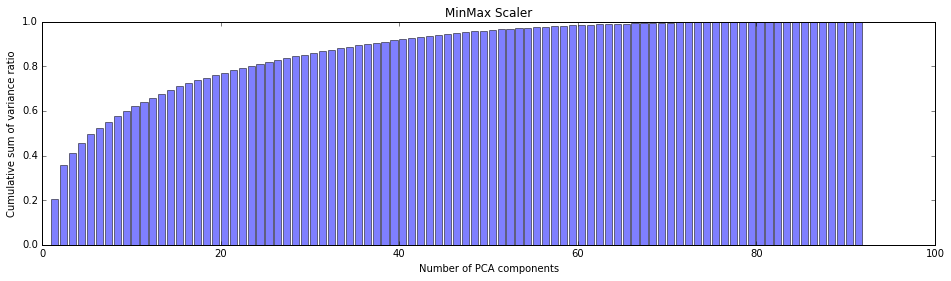

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=scaledX.shape[1])
pca.fit(scaledX)

print pca.explained_variance_ratio_

plt.figure(figsize=(16,4))
plt.title('MinMax Scaler')
plt.ylim([0, 1])
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), alpha=0.5)
plt.ylabel('Cumulative sum of variance ratio')
plt.xlabel('Number of PCA components')
plt.show()

The first 40 PCA components seem to count for more than 95% of the variance. 

In [8]:
pca = PCA(n_components=55)
pca.fit(scaledX)
finalX = pca.transform(scaledX)

print finalX.shape

(5960, 55)


### Train / test split

Optionally store the train/test split in a pickle file if we want to keep the same train/test data. In order to do this, comment out the os.remove line. 

(4768, 55)
(1192, 55)
(4768, 2)
(1192, 2)
       y_test c150  y_train c150
count  1192.000000   4768.000000
mean      0.519945      0.529387
std       0.236218      0.237502
min       0.000000      0.000000
25%       0.320393      0.343223
50%       0.546838      0.554140
75%       0.702200      0.723176
max       1.000000      1.000000
        y_test ret  y_train ret
count  1192.000000  4768.000000
mean      0.694919     0.698920
std       0.166950     0.168766
min       0.083300     0.019200
25%       0.591875     0.590700
50%       0.705900     0.710000
75%       0.806425     0.821400
max       1.000000     1.000000


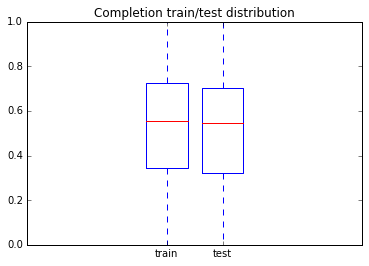

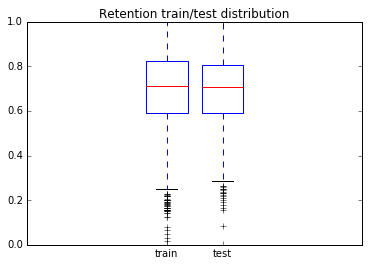

In [9]:
from sklearn import cross_validation as cv

pickle_file = 'm5-split_data.pickle'

os.remove(pickle_file) # clear cache (delete pickle). Comment this out to keep the same train/test data over multiple runs
if os.path.isfile(pickle_file):
    print "loading split_data from pickle"
    split_data = pickle.load(open(pickle_file, "rb"))
    X_train, X_test, y_train, y_test = split_data['X_train'], split_data['X_test'], split_data['y_train'], split_data['y_test']
else:
    y = np.array(y)
    X_train, X_test, y_train, y_test = cv.train_test_split(finalX, y, train_size=0.8)
    split_data = {
        'X_train': X_train,
        'X_test':  X_test,
        'y_train': y_train,
        'y_test':  y_test,        
    }
    pickle.dump(split_data, open(pickle_file, "wb"))

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

# Check if the train / test has similar distribution
print pd.DataFrame(data={'y_train c150': pd.Series(y_train[:,0]).describe(),
                         'y_test c150': pd.Series(y_test[:,0]).describe(),
                        })
print pd.DataFrame(data={'y_train ret': pd.Series(y_train[:,1]).describe(),
                         'y_test ret': pd.Series(y_test[:,1]).describe(),
                        })
plt.title("Completion train/test distribution")
plt.boxplot([y_train[:,0], y_test[:,0]], labels=['train', 'test'], positions=[0.2, 0.4])
plt.show()
plt.title("Retention train/test distribution")
plt.boxplot([y_train[:,1], y_test[:,1]], labels=['train', 'test'], positions=[0.2, 0.4])
plt.show()


## Build models

### Decision Tree

--- R2 Completion ---
best params: {'max_depth': 7}
R2 score on train data: 0.690138882993
R2 score on test  data: 0.522426180148
--- R2 Retention ---
best params: {'max_depth': 5}
R2 score on train data: 0.317312018822
R2 score on test  data: 0.237893192551
--- MSE Completion ---
MSE on train data: 0.017474732951
MSE on test  data: 0.0266257638584
--- MSE Retention ---
MSE on train data: 0.0194403053152
MSE on test  data: 0.0212239286371
--- MAE Completion ---
MAE on train data: 0.0984501219035
MAE on test  data: 0.116841235449
--- MAE Retention ---
MAE on train data: 0.101861371716
MAE on test  data: 0.105310863419


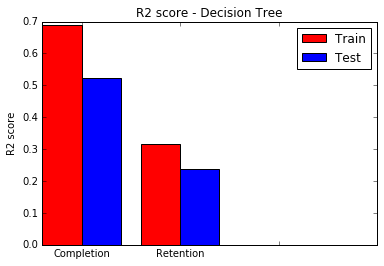

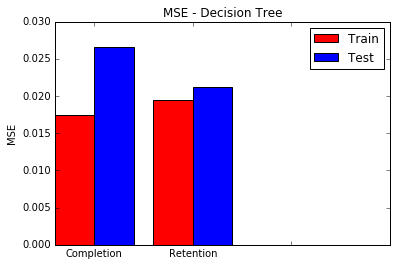

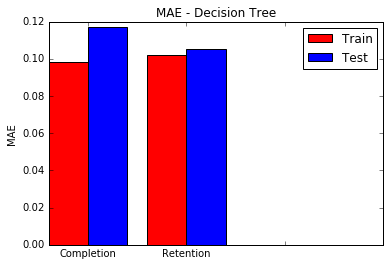

In [10]:
DT_model = build_DecisionTree_model(X_train, X_test, y_train, y_test)

### SVR

--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 10.0, 'gamma': 0.10000000000000001}
R2 score on train data: 0.749076508833
R2 score on test  data: 0.594431424889
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.340478963205
R2 score on test  data: 0.311879759147
--- MSE Completion ---
MSE on train data: 0.014150923619
MSE on test  data: 0.0226113171627
--- MSE Retention ---
MSE on train data: 0.018780600612
MSE on test  data: 0.0191634751755
--- MAE Completion ---
MAE on train data: 0.0895223115791
MAE on test  data: 0.106560161531
--- MAE Retention ---
MAE on train data: 0.0982606026219
MAE on test  data: 0.0971128146725


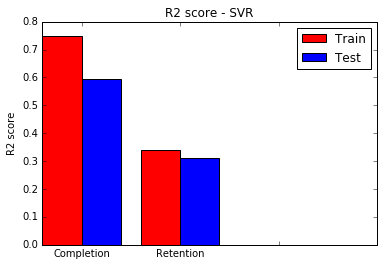

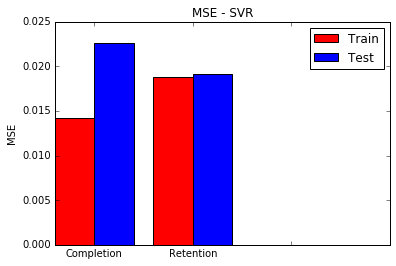

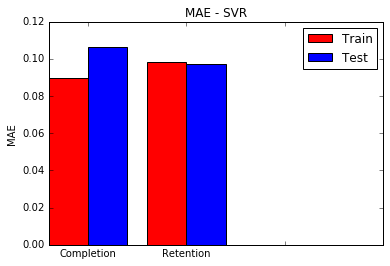

In [11]:
SVR_model = build_SVR_model(X_train, X_test, y_train, y_test)

### KNN

--- R2 Completion ---
best params: {'n_neighbors': 7}
R2 score on train data: 0.74854609514
R2 score on test  data: 0.592862332212
--- R2 Retention ---
best params: {'n_neighbors': 19}
R2 score on train data: 0.367462147267
R2 score on test  data: 0.286282708483
--- MSE Completion ---
MSE on train data: 0.0141808364965
MSE on test  data: 0.0226987974419
--- MSE Retention ---
MSE on train data: 0.0180122242072
MSE on test  data: 0.019876327982
--- MAE Completion ---
MAE on train data: 0.0883877998985
MAE on test  data: 0.10715041506
--- MAE Retention ---
MAE on train data: 0.0964069443218
MAE on test  data: 0.10096062787


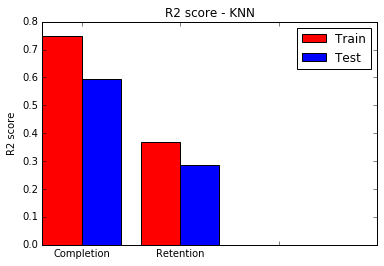

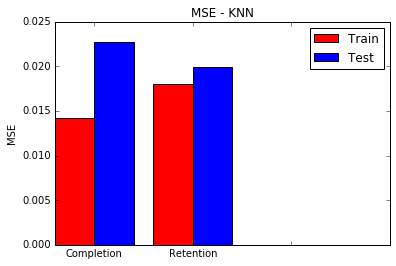

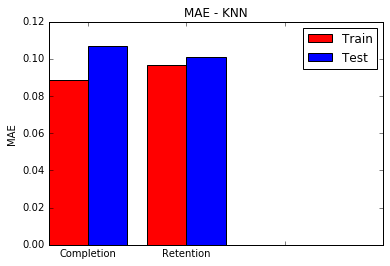

In [12]:
KNN_model = build_KNN_model(X_train, X_test, y_train, y_test)

### Random Forest

--- R2 Completion ---
R2 score on train data: 0.954042259758
R2 score on test  data: 0.63326589363
--- R2 Retention ---
R2 score on train data: 0.901492724808
R2 score on test  data: 0.342339741444
--- MSE Completion ---
MSE on train data: 0.00259180385557
MSE on test  data: 0.0204462123113
--- MSE Retention ---
MSE on train data: 0.00280510505282
MSE on test  data: 0.0183151944827
--- MAE Completion ---
MAE on train data: 0.0368465060585
MAE on test  data: 0.101059113847
--- MAE Retention ---
MAE on train data: 0.0373355370523
MAE on test  data: 0.0960692372563


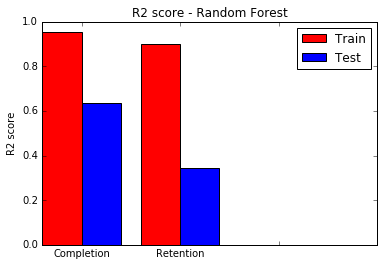

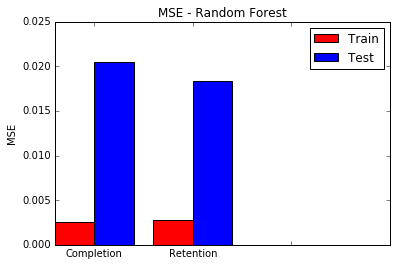

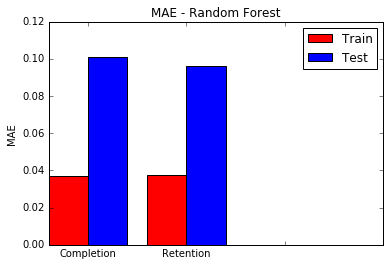

In [13]:
RF_model = build_RandomForest_model(X_train, X_test, y_train, y_test, n_estimators=50)

### Comparing R2, MSE and MAE between models

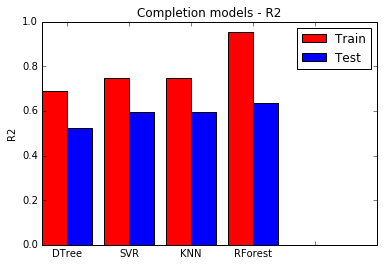

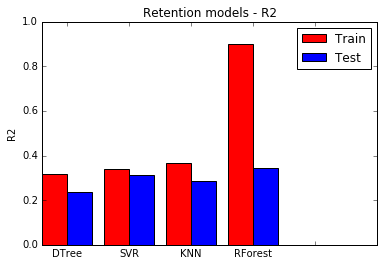

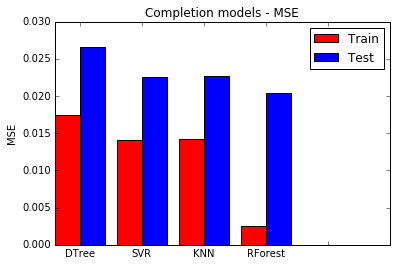

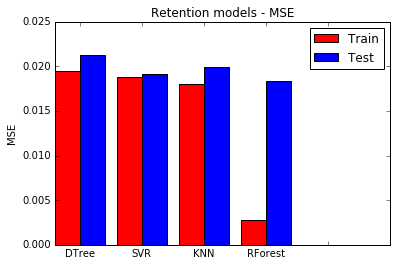

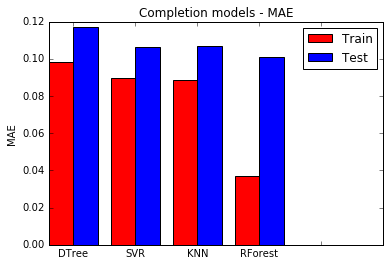

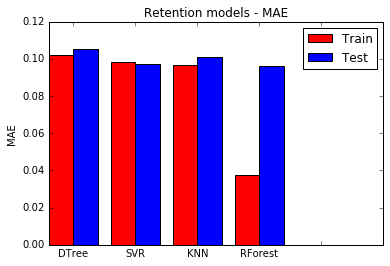

In [14]:
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='r2')
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mse')
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mae')

### Sensitivity analysis

Sensitivity analysis is done by choosing 100 random data from the training set and changing the input by a little bit to see how different the prediction result for each model is. The difference in prediction result are collected and visualized using whisker plot to see the stability of the model.

Statistical analysis of difference in result when the input have small changes


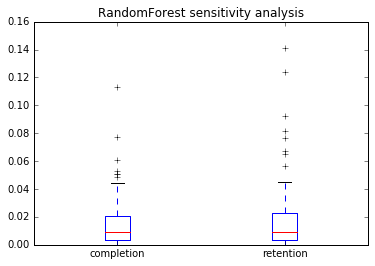

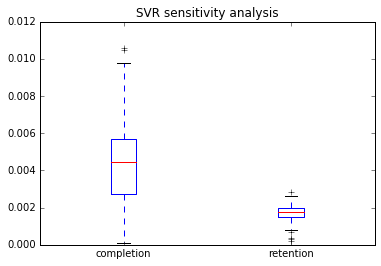

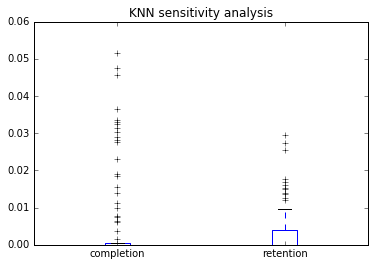

In [15]:

def final_model_predict(reg1, reg2, X):
    y1_predicted = reg1.predict(X)
    y2_predicted = reg2.predict(X)
    return y1_predicted, y2_predicted

def sensitivity_analysis(reg1, reg2, data, title=''):
    delta_y1, delta_y2 = [], []
    
    for i, row in enumerate(data):
        X_nearby = row.copy()
        for j, a in enumerate(X_nearby):
            span = X_train[:,j].max() - X_train[:,j].min()
            if j < 15:
                X_nearby[j] += span/200

        y1p, y2p = final_model_predict(reg1, reg2, [row]) # predicted value
        y1pn, y2pn = final_model_predict(reg1, reg2, [X_nearby]) # predicted nearby value
        delta_y1.append(abs(y1pn[0] - y1p[0]))
        delta_y2.append(abs(y2pn[0] - y2p[0]))
    
    plt.title("{} sensitivity analysis".format(title))
    plt.boxplot([delta_y1, delta_y2], labels=['completion', 'retention'])
    plt.show()

print "Statistical analysis of difference in result when the input have small changes"
# Just test on a subset of the data (because it's really slow)
X_train_subset = X_train[np.random.choice(len(X_train), 100, replace=False)]

sensitivity_analysis(RF_model['reg1'], RF_model['reg2'], data=X_train_subset, title='RandomForest')
sensitivity_analysis(SVR_model['reg1'], SVR_model['reg2'], data=X_train_subset, title='SVR')
sensitivity_analysis(KNN_model['reg1'], KNN_model['reg2'], data=X_train_subset, title='KNN')


### Prediction error distribution

Metric only goes so far as telling as the mean absolute error, or the R2 score with just one number. 
To get a better idea how our model performs, we'll look at the prediction error on the test data and create histogram of the error distribution, so we can tell what's the percentage the model get it close, and what's the percentage it does really poorly.

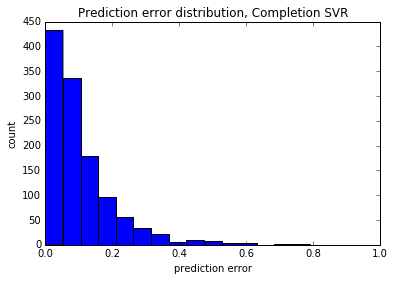

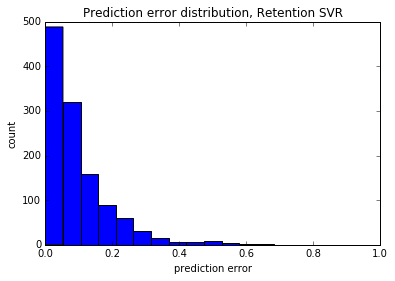

In [16]:
hist_plot_delta(SVR_model, X_test, y_test, model_name='SVR')

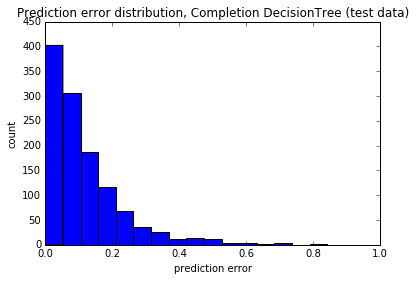

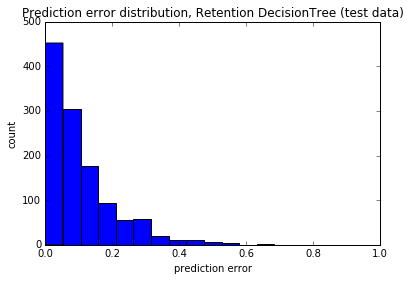

In [17]:
hist_plot_delta(DT_model, X_test, y_test, model_name='DecisionTree (test data)')

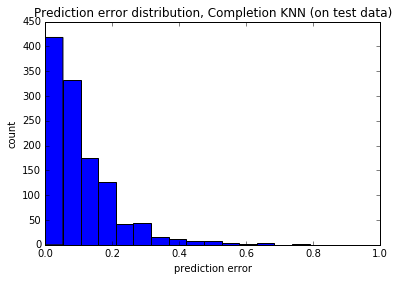

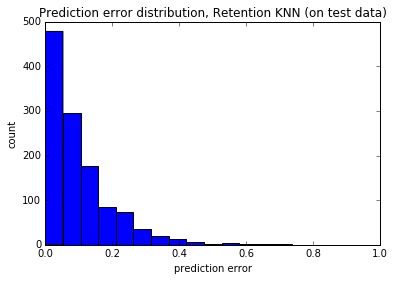

In [18]:
hist_plot_delta(KNN_model, X_test, y_test, model_name='KNN (on test data)')

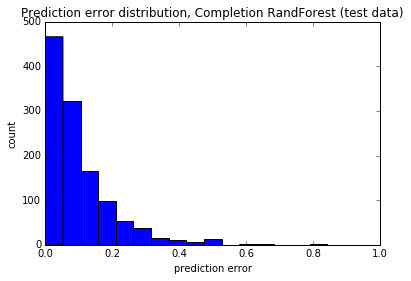

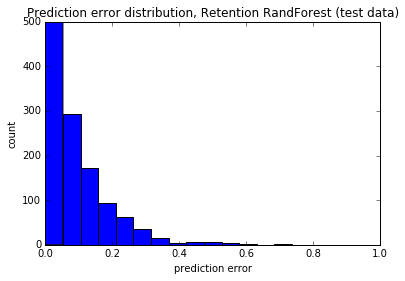

In [19]:
hist_plot_delta(RF_model, X_test, y_test, model_name='RandForest (test data)')

### Error distribution comparison between models

The following histogram plots show how different models perform. Even though some models have similar R2 and MAE, they don't always make the same prediction. This comparison shows how the models trade off error distribution.

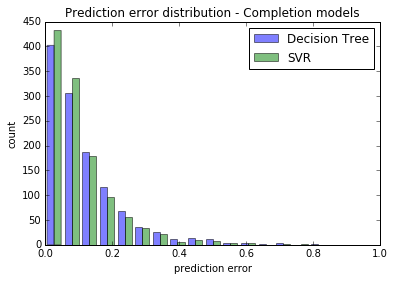

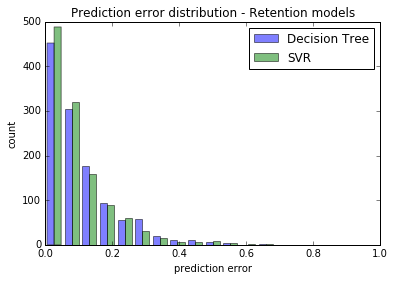

In [20]:
compare_hist_plot_delta(DT_model, SVR_model, X_test, y_test, ['Decision Tree', 'SVR'])

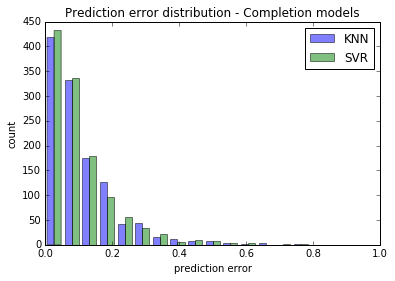

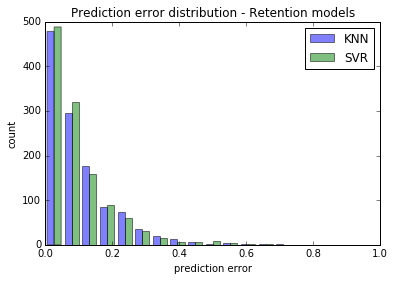

In [21]:
compare_hist_plot_delta(KNN_model, SVR_model, X_test, y_test, ['KNN', 'SVR'])